-------------
### ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
TARGET = "visit"  #'conversion', 'visit'
TRAIN_SIZE = 100000
TEST_SIZE = 100000
THRESHOLD_LIST = [2]  # 外れ値除外の閾値

RANDOM_STATE = 0  # 乱数シード

-----------
### データの前処理

In [3]:
df_all = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\criteo-uplift-v2.1.csv.gz", sep=",", header=None
)

df_all.columns = df_all.iloc[0]  # 0行目を列名にする
df_all = df_all[1:].reset_index(drop=True)

column_names = df_all.columns.tolist()
print("列名:", column_names)

df_control = df_all[df_all["treatment"] == 0]
df_treatment = df_all[df_all["treatment"] == 1]
df_other = df_all[(df_all["treatment"] != 0) & (df_all["treatment"] != 1)]
print(df_control)
print(df_treatment)

features_list = [
    "f0",
    "f1",
    "f2",
    "f3",
    "f4",
    "f5",
    "f6",
    "f7",
    "f8",
    "f9",
    "f10",
    "f11",
]
ALL_FEATURES_INDEX = [i for i in range(len(features_list))]

df_train = df_control.iloc[:TRAIN_SIZE]
df_test = df_control.iloc[100000 : TEST_SIZE + 100000]

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_26440\3732050434.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(


列名: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'treatment', 'conversion', 'visit', 'exposure']
0                f0         f1        f2        f3         f4        f5  \
5571799   12.974809  10.059654  8.761255  2.293959  10.280525  4.115453   
5571800   16.177822  10.059654  8.214383  3.359763  10.280525  4.115453   
5571801   12.616365  10.059654  8.497501  4.679882  10.280525  4.115453   
5571802   26.683908  10.059654  8.214383  4.679882  10.280525  4.115453   
5571803   24.359765  10.059654  8.214383  4.679882  10.280525  4.115453   
...             ...        ...       ...       ...        ...       ...   
13168501  12.616365  10.059654  9.050352  4.679882  10.280525  4.115453   
13168502  12.616365  10.059654  9.037968  4.679882  10.280525  4.115453   
13168503  12.616365  10.059654  8.815655  4.679882  10.280525  4.115453   
13168504  15.950327  10.059654  8.412691 -1.025575  10.280525  4.115453   
13168505  12.616365  10.059654  8.866528  4.6798

In [16]:
print(len(df_all))
print(len(df_control))
print(len(df_treatment))
print(len(df_other))
unique_values = df_treatment["exposure"].unique()
print(unique_values)


13979592
2096937
11849888
32767
[0 1]


欠損値除去

In [5]:
def remove_nan(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 各列に対して、pd.to_numericを使用して数値に変換（エラーがあればNaNにする）
    df_numeric = data.apply(lambda col: pd.to_numeric(col, errors="coerce"))

    # 数値に変換できなかった行を抽出（NaNを含む行）
    df_excluded = data[df_numeric.isna().any(axis=1)]

    # NaNを含む行を削除
    df_clean = df_numeric.dropna()

    return df_excluded, df_clean

In [6]:
df_train_ex, df_train_clean = remove_nan(df_train)
df_test_ex, df_test_clean = remove_nan(df_test)
print(df_train_ex)
print(df_train_clean)
print()
print(df_test_ex)
print(df_test_clean)

Empty DataFrame
Columns: [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, treatment, conversion, visit, exposure]
Index: []
0               f0         f1        f2        f3         f4        f5  \
5571799  12.974809  10.059654  8.761255  2.293959  10.280525  4.115453   
5571800  16.177822  10.059654  8.214383  3.359763  10.280525  4.115453   
5571801  12.616365  10.059654  8.497501  4.679882  10.280525  4.115453   
5571802  26.683908  10.059654  8.214383  4.679882  10.280525  4.115453   
5571803  24.359765  10.059654  8.214383  4.679882  10.280525  4.115453   
...            ...        ...       ...       ...        ...       ...   
5671794  22.723913  10.059654  8.214383  4.679882  10.280525  4.115453   
5671795  23.767681  10.059654  8.214383  4.679882  10.280525  4.115453   
5671796  26.109300  10.059654  8.214383  4.679882  10.280525  4.115453   
5671797  22.483665  10.059654  8.214383  4.679882  10.280525  4.115453   
5671798  12.616365  10.059654  8.787649  4.679882  10.280525

-------------
### 外れ値を除外しない場合

In [7]:
df = df_train_clean

全データ数： 100000
0のデータ数： 97750
1のデータ数： 2250
分散： 0.02199375000000001


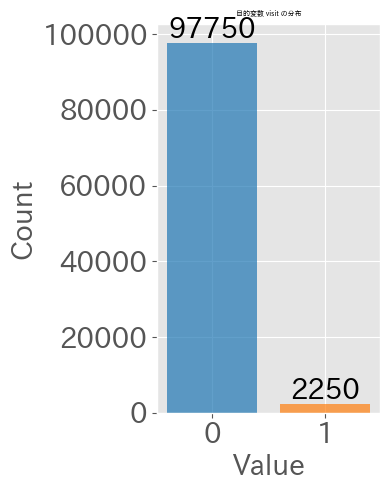

In [8]:
y = df[TARGET]
print("全データ数：", len(df))
print("0のデータ数：", len(y[y == 0]))
print("1のデータ数：", len(y[y == 1]))
print("分散：", np.var(y))
# 値が0と1のデータ数を計算
counts = y.value_counts()
labels = counts.index  # [0, 1]
values = counts.values  # [count_0, count_1]

# プロット
fig, ax = plt.subplots(figsize=(4, 5))
bars = ax.bar(labels, values, color=["#1f77b4", "#ff7f0e"], alpha=0.7)

# 各バーの上に数値を表示
for bar, value in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # バーの中央
        bar.get_height(),  # バーの高さ
        f"{value}",  # 表示する数値
        ha="center",
        va="bottom",
        fontsize=20,
    )

# ラベルとタイトルを設定
ax.set_title(f"目的変数 {TARGET} の分布", fontsize=5)
ax.set_xlabel("Value", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_xticks([0, 1])  # 横軸の位置を0と1に設定
ax.set_xticklabels(["0", "1"], fontsize=20)  # ラベルを明示的に指定
ax.tick_params(axis="both", labelsize=20)

plt.tight_layout()
plt.show()

-------------
### 外れ値除外

In [9]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

閾値：2
外れ値除外前のデータ数（訓練+テスト）: 100000
外れ値除外後のデータ数（訓練+テスト）: 97750
除外されたデータ数： 2250


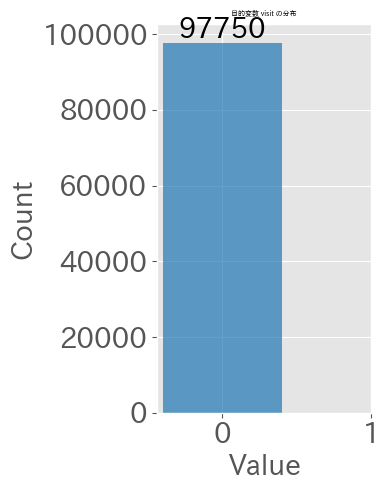

In [10]:
for i in range(len(THRESHOLD_LIST)):
    df_outliers_removed = remove_outliers_zscore(
        data=df, metric=TARGET, threshold=THRESHOLD_LIST[i]
    )
    df_outliers_removed = df_outliers_removed.reset_index(drop=True)  # 行を詰める
    y = df_outliers_removed[TARGET]
    print(f"閾値：{THRESHOLD_LIST[i]}")
    print("外れ値除外前のデータ数（訓練+テスト）:", len(df_train))
    print("外れ値除外後のデータ数（訓練+テスト）:", len(df_outliers_removed))
    print("除外されたデータ数：", len(df_train) - len(df_outliers_removed))

    counts = y.value_counts()
    labels = counts.index  # [0, 1]
    values = counts.values  # [count_0, count_1]

    # プロット
    fig, ax = plt.subplots(figsize=(4, 5))
    bars = ax.bar(labels, values, color=["#1f77b4", "#ff7f0e"], alpha=0.7)

    # 各バーの上に数値を表示
    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # バーの中央
            bar.get_height(),  # バーの高さ
            f"{value}",  # 表示する数値
            ha="center",
            va="bottom",
            fontsize=20,
        )

    # ラベルとタイトルを設定
    ax.set_title(f"目的変数 {TARGET} の分布", fontsize=5)
    ax.set_xlabel("Value", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.set_xticks([0, 1])  # 横軸の位置を0と1に設定
    ax.set_xticklabels(["0", "1"], fontsize=20)  # ラベルを明示的に指定
    ax.tick_params(axis="both", labelsize=20)

    plt.tight_layout()
    plt.show()